In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml
except:
    pass

# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.utils import load_hyperparameters, QFDataset, weizsaecker_functional, weizsaecker_functional_derivative, integrate, anim_plot

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
TensorFlow 2.x selected.
     |████████████████████████████████| 112kB 9.1MB/s 
     |████████████████████████████████| 552kB 29.5MB/s 


In [0]:
def normalise(function, h):
    integral = integrate(function**2, h)
    function /= tf.sqrt(tf.expand_dims(integral, axis=1))
    return function

def normalise_density(density, h):
    integral = integrate(density, h)
    density /= tf.expand_dims(integral, axis=1)
    return density

class LocalPCA(tf.Module):
    def __init__(self, X_train, m, l, pseudo=False):
        super().__init__()
        if pseudo:
            self.X_train = tf.Variable(initial_value=np.sqrt(X_train))
        else:
            self.X_train = tf.Variable(initial_value=X_train)
        self.m = tf.Variable(initial_value=m)
        self.l = tf.Variable(initial_value=l)
        self.pseudo = pseudo

    @tf.function
    def projection_subspace(self, X):
        metric = tf.reduce_sum(tf.square(tf.expand_dims(X, axis=2) - tf.expand_dims(tf.transpose(self.X_train), axis=0)), axis=1)
        _, closest_indices = tf.math.top_k(-metric, k=self.m)
        X_closest = tf.gather(self.X_train, closest_indices)

        X_diff = tf.expand_dims(X, axis=1) - X_closest
        C = tf.linalg.matmul(X_diff, X_diff, transpose_a=True)/tf.cast(self.m, X.dtype)

        eigen_vals, eigen_vecs = tf.linalg.eigh(C)
        return eigen_vecs[:, :, -self.l:]

    @tf.function
    def __call__(self, X, functional_derivative):
        projection_subspace = self.projection_subspace(X)
        if self.pseudo:
            X = tf.math.sqrt(X)
        return tf.reduce_sum(tf.linalg.matmul(projection_subspace, tf.linalg.matmul(projection_subspace, tf.expand_dims(functional_derivative, axis=2), transpose_a=True)), axis=-1)


class SelfConsistentDensity(tf.Module):
    def __init__(self, model, vW_model, project, params):
        self.model = model
        self.vW_model = vW_model
        self.project = project
        self.dtype = params['dtype']
        self.step_size = params['step_size']
        self.iterations = params['iterations']
        self.subtract_von_weizsaecker = params['model_subtract_von_weizsaecker']
        self.von_weizsaecker_factor = params.get('model_von_weizsaecker_factor', 1.0)
        self.model_dtype = params['model_dtype']
        self.N = params['N']
        self.h = params['dataset']['h']

        self.recordings = {}
        self.record = params.get('record', {})   

    @tf.function
    def step(self, density, potential):
        with tf.GradientTape() as tape:
            tape.watch(density)
            model_kinetic_energy = self.model(tf.cast(density, dtype=self.model_dtype))

        model_derivative = 1/self.h*tape.gradient(model_kinetic_energy, density)

        with tf.GradientTape() as tape:
            tape.watch(density)
            vW_kinetic_energy = self.vW_model(density)

        vW_derivative = 1/self.h*tape.gradient(vW_kinetic_energy, density)

        model_derivative = tf.cast(model_derivative, dtype=self.dtype)

        derivative = model_derivative + self.von_weizsaecker_factor*self.subtract_von_weizsaecker*vW_derivative

        functional_derivative = derivative + potential
        
        functional_derivative = self.project(density, functional_derivative)

        new_density = density  - self.step_size*functional_derivative

        if params['normalize']:
            new_density = normalise_density(new_density, params['dataset']['h'])*self.N

        return new_density, functional_derivative, model_derivative, vW_derivative

    def train(self, potential, initial_density, progress=None):
        if progress is not None:
            progress.max = self.iterations+1
        
        self.recordings = {}
        for key in self.record.keys():
            self.recordings[key] = []

        density = initial_density
        for i in range(self.iterations+1):
            if progress is not None and i % (self.iterations//100) == 0:
                progress.value = i + 1

            density, functional_derivative, model_derivative, vW_derivative = self.step(density, potential)

            density = tf.debugging.check_numerics(density, message='Invalid value encountered for new_density, step {}.'.format(i+1))

            if 'density' in self.record and i % self.record['density'] == 0: self.recordings['density'].append(density[:self.record['M']].numpy())
            if 'model_derivative' in self.record and i % self.record['model_derivative'] == 0: self.recordings['model_derivative'].append(model_derivative[:self.record['M']].numpy())
            if 'vW_derivative' in self.record and i % self.record['vW_derivative'] == 0: self.recordings['vW_derivative'].append(vW_derivative[:self.record['M']].numpy())
            if 'functional_derivative' in self.record and i % self.record['functional_derivative'] == 0: self.recordings['functional_derivative'].append(functional_derivative[:self.record['M']].numpy())

        return density

    def get_recordings(self):
        for key in self.record.keys():
            self.recordings[key] = np.array(self.recordings[key])
        return self.recordings

class vWModel():
    @tf.custom_gradient
    def __call__(self, density):
        def grad(kinetic_energy):
            return 1/499*weizsaecker_functional_derivative(density, 1/499)
        return {'kinetic_energy': weizsaecker_functional(density, 1/499)}, grad


def model_performance(params, model, vW_model, dataset, density=None):
    if density is None:
        density = tf.constant(dataset.density)

    model_kinetic_energy = model(tf.cast(density, dtype=params['model_dtype']))['kinetic_energy']
    vW_kinetic_energy = vW_model(density)['kinetic_energy']

    model_kinetic_energy = tf.cast(model_kinetic_energy, dtype=params['dtype'])

    vW_kinetic_energy = weizsaecker_functional(density, params['dataset']['h'])
    kinetic_energy = model_kinetic_energy + params.get('model_von_weizsaecker_factor', 1.0)*params['model_subtract_von_weizsaecker']*vW_kinetic_energy

    kenergies_err = np.abs(kinetic_energy - dataset.kinetic_energy)*kcalmol_per_hartree

    print('MAE:', np.nanmean(kenergies_err))
    print('AE_std:', np.std(kenergies_err))
    print('AE_max:', np.max(kenergies_err))

    plt.figure(figsize=figsize, dpi=dpi)
    plt.hist(kenergies_err, bins=100)
    plt.title('Kinetic Energy Absolute Error')
    plt.xlabel('kcal/mol')
    plt.show()

    '''
    plt.figure(figsize=(20, 5), dpi=dpi)
    plt.plot(dataset.x, tf.transpose(model_derivative[:preview]))
    plt.gca().set_prop_cycle(None)
    plt.plot(dataset.x, tf.transpose(dataset.vW_derivative[:preview]), ':')
    plt.gca().set_prop_cycle(None)
    plt.plot(dataset.x, tf.transpose(derivative[:preview]))
    plt.plot(dataset.x, tf.transpose(dataset.derivative[:preview]), 'k--')
    plt.show()

    functional_derivative = derivative + dataset.potential
    functional_derivative_proj = project(density, functional_derivative)

    plt.figure(figsize=(20, 5), dpi=dpi)
    plt.plot(dataset.x, tf.transpose(functional_derivative[:preview]), ':')
    plt.gca().set_prop_cycle(None)
    plt.plot(dataset.x, tf.transpose(functional_derivative_proj[:preview]))
    plt.grid()
    plt.ylim([-10, 10])
    plt.show()
    '''

In [3]:
%%writefile /tmp/hparams.yaml

default: &DEFAULT
    model: null
    model_dtype: float32

    dataset: datasets/dataset_test.hdf5
    train_dataset: datasets/dataset_paper.hdf5

    N: 1
    dtype: float64
    model_subtract_von_weizsaecker: False
    model_von_weizsaecker_factor: 1

    initial_density: mean # mean, zeroV

    iterations: 1000
    step_size:  0.001
    normalize: False

    record: 
        M: 10
        pseudo: 10
        density: 10
        model_derivative: 10
        vW_derivative: 10
        functional_derivative: 10

pca: &PCA
    projection_method: 'pca'
    pca_kwargs: 
        m: 30
        l: 5
        pseudo: False

tangent: &TANGENT
    projection_method: 'tangent'
    normalize: True

sines: &SINES
    projection_method: 'sines'
    sines_n: 10
    normalize: True

vW: &VW
    N: 2
    projection_method: 'sines'
    projection_arg: 10
    von_weizsaecker_factor: 1.0
    normalize: False

######################

plain_vW: 
    <<: [*VW, *DEFAULT]
    model: null
    model_dtype: float64

    N: 1
    projection_method: null #'sines'
    projection_arg: 50
    normalize: True

    iterations: 100000
    step_size:  0.00001

    record: 
        density: 2000
        functional_derivative: 2000

krr: &KRR
    <<: [*PCA, *DEFAULT]
    model: ke_krr/default/saved_model
    model_dtype: float64

cnn: &CNN
    <<: [*PCA, *DEFAULT]
    model: kd_cnn/cnn/seed0/saved_model

resnet: &RESNET
    <<: [*PCA, *DEFAULT]
    model: kd_cnn/resnet/seed0/saved_model

cnn_sines: 
    <<: [*SINES, *CNN]

cnn_tangent:
    <<: [*TANGENT, *CNN]


Writing /tmp/hparams.yaml


MAE: 0.0878163810461549
AE_std: 0.2838183110722434
AE_max: 7.507171832133071


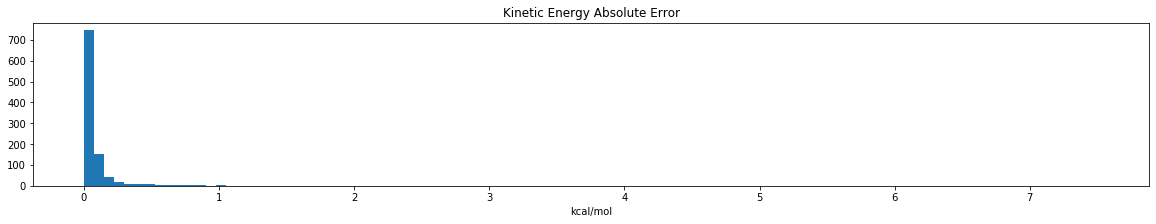

In [0]:
run_name = 'cnn_sines'
preview = 5
figsize = (20, 3)
dpi = None
kcalmol_per_hartree = 627.51
params = load_hyperparameters('/tmp/hparams.yaml', run_name=run_name)

dataset = QFDataset(os.path.join(data_dir, params['dataset']), params)
dataset_train = QFDataset(os.path.join(data_dir, params['train_dataset']), params)
params['dataset'] = dataset.get_params(shapes=False, h=True)

vW_model = model = vWModel()

if params['model']:
    model = tf.saved_model.load(os.path.join(data_dir, params['model']))

if params['projection_method'] == 'pca':
    projection_model = LocalPCA(dataset_train.density, **params['pca_kwargs'])
    project = lambda density, functional_derivative: projection_model(density, functional_derivative)
elif params['projection_method'] == 'sines':
    n_basis = params['sines_n']
    basis = np.sqrt(2)*np.sin(dataset.x[np.newaxis, :]*np.pi*np.arange(1, n_basis+1)[:, np.newaxis])
    '''
    n_basis = params['projection_arg']
    basis = np.sqrt(2)*np.sin(dataset.x[np.newaxis, :]*np.pi*np.arange(1, n_basis+2)[:, np.newaxis])

    gram_schmid = np.zeros((n_basis, n_basis+1))
    gram_schmid[list(range(0, n_basis, 2)), list(range(1, n_basis+1, 2))] = 1
    gram_schmid[list(range(1, n_basis, 2)), list(range(0, n_basis-1, 2))] = range(1, n_basis, 2)
    gram_schmid[list(range(1, n_basis, 2)), list(range(2, n_basis+1, 2))] = [-i for i in range(3, n_basis+2, 2)]

    for row in range(3, n_basis, 2):
        gram_schmid[row] = gram_schmid[row] - gram_schmid[row-2]*(np.sum(gram_schmid[row]*gram_schmid[row-2])/np.sum(gram_schmid[row-2]*gram_schmid[row-2]))

    gram_schmid /= np.sqrt(np.sum(np.square(gram_schmid), axis=1)[:, np.newaxis])
    basis = np.matmul(gram_schmid, basis)

    project = lambda density, functional_derivative: dataset.h*tf.matmul(tf.matmul(basis, functional_derivative, transpose_b=True), basis, transpose_a=True)
    '''    
    project = lambda density, functional_derivative: tf.square(dataset.h*tf.matmul(tf.matmul(basis, tf.math.sqrt(tf.abs(functional_derivative)), transpose_b=True), basis, transpose_a=True))
elif params['projection_method'] == 'tangent':
    project = lambda density, functional_derivative: functional_derivative - integrate(functional_derivative*density)*density
else:
    project = lambda density, functional_derivative: functional_derivative

model_performance(params, model, vW_model, dataset)

In [0]:
batch_size = 100
assert dataset.dataset_size % batch_size == 0

progress = widgets.IntProgress(value=0, max=0, description='...', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

IntProgress(value=0, bar_style='info', description='...', layout=Layout(width='92%'), max=0)

In [0]:
import time

self_consistency_method = SelfConsistentDensity(model, vW_model, project, params=params)

if params['initial_density'] == 'mean':
    initial_density = np.repeat(np.expand_dims(np.mean(dataset_train.density, axis=0), axis=0), dataset.dataset_size, axis=0)
elif params['initial_density'] == 'zeroV':
    initial_density = normalise_density(np.repeat(np.sin(x[np.newaxis, :]*np.pi)**2, M, axis=0))*N

self_consistent_densities = []

start = time.time()
for batch in range(dataset.dataset_size // batch_size):
    progress.description = str(batch+1) + '/' + str(dataset.dataset_size // batch_size)
    self_consistent_densities.append(self_consistency_method.train(dataset.potential[batch*batch_size:(batch+1)*batch_size], initial_density[batch*batch_size:(batch+1)*batch_size], progress=progress))
duration = time.time() - start
print('duration:', duration, 'seconds')

self_consistent_density = np.concatenate(self_consistent_densities, axis=0)

model_performance(params, model, vW_model, dataset, density=self_consistent_density)

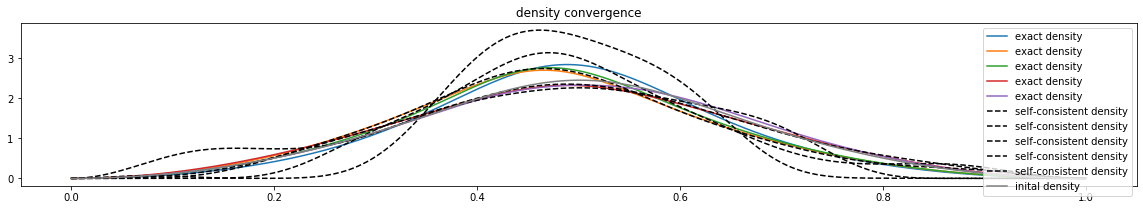

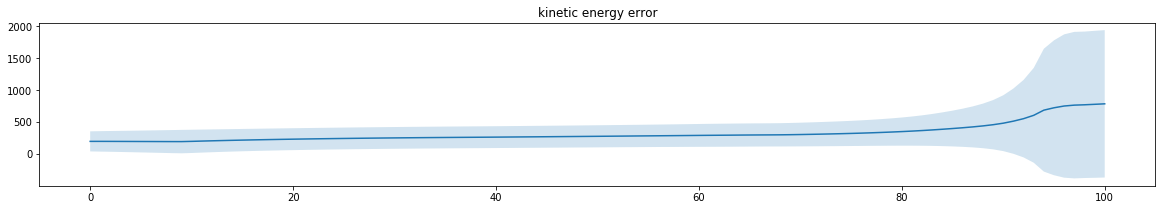

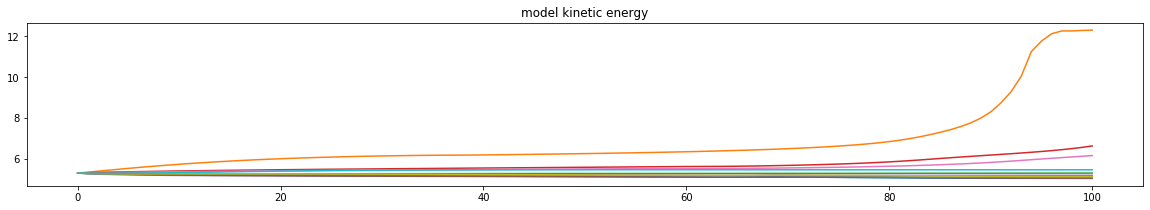

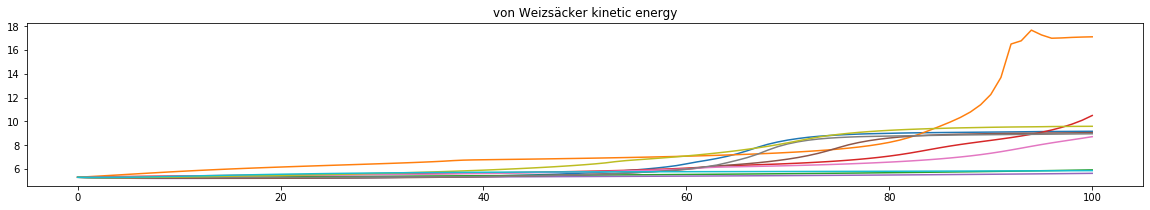

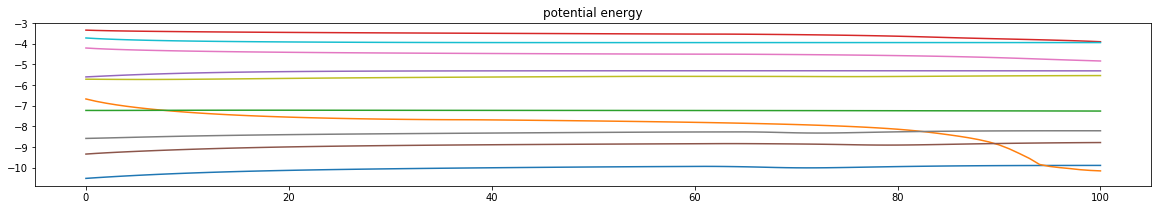

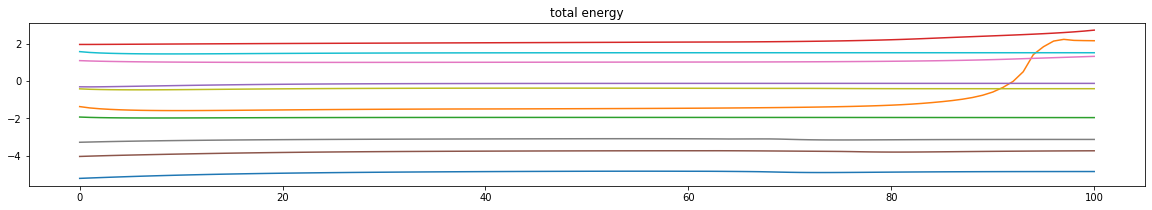

In [0]:
recordings = self_consistency_method.get_recordings()

preview = 5
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset.x, np.transpose(dataset.density[:preview]), label='exact density')
plt.plot(dataset.x, np.transpose(self_consistent_density[:preview]), 'k--', label='self-consistent density')
plt.plot(dataset.x, np.transpose(initial_density[0:1]), 'grey', label='inital density')
plt.legend()
plt.title('density convergence')
plt.show()

model_kinetic_energy = []
kinetic_energy = []
potential_energy = []
vW_kinetic_energy = []

for density_step in recordings['density']:
    density_step = tf.constant(density_step)

    model_kinetic_energy_step = model(tf.cast(density_step, dtype=params['model_dtype']))['kinetic_energy']
    model_kinetic_energy_step = tf.cast(model_kinetic_energy_step, dtype=params['dtype'])

    vW_kinetic_energy_step = vW_model(density_step)['kinetic_energy']
    potential_energy_step = integrate(density_step*dataset.potential[:params['record']['M']], params['dataset']['h'])

    model_kinetic_energy.append(model_kinetic_energy_step.numpy())
    vW_kinetic_energy.append(vW_kinetic_energy_step.numpy())
    potential_energy.append(potential_energy_step.numpy())

model_kinetic_energy = np.stack(model_kinetic_energy, axis=0)
vW_kinetic_energy = np.stack(vW_kinetic_energy, axis=0)
potential_energy = np.stack(potential_energy, axis=0)

kinetic_energy = model_kinetic_energy + params.get('model_von_weizsaecker_factor', 1.0)*params['model_subtract_von_weizsaecker']*vW_kinetic_energy

kenergies_err = np.abs(tf.expand_dims(dataset.kinetic_energy[:params['record']['M']], axis=0) - kinetic_energy)*kcalmol_per_hartree
kenergies_err_mean = np.mean(kenergies_err, axis=1)
kenergies_err_std = np.std(kenergies_err, axis=1)

plt.figure(figsize=figsize, dpi=dpi)
plt.fill_between(np.arange(len(kenergies_err_mean)), kenergies_err_mean - kenergies_err_std, kenergies_err_mean + kenergies_err_std, alpha=0.2)
plt.plot(kenergies_err_mean)
#plt.ylim([0, 10])
plt.title('kinetic energy error')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(model_kinetic_energy)

plt.title('model kinetic energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(vW_kinetic_energy)
plt.title('von Weizsäcker kinetic energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(potential_energy)
plt.title('potential energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(potential_energy + kinetic_energy)
plt.title('total energy')
plt.show()


In [0]:
print('densities')
anim_plot(np.moveaxis(recordings['density'], 2, 1), bar='Rendering')
print('densities err')
anim_plot(np.moveaxis(recordings['density'] - np.expand_dims(dataset.density[:params['record']['M']], axis=0), 2, 1), bar='Rendering')
print('functional derivatives')
anim_plot(np.moveaxis(recordings['functional_derivative'], 2, 1), bar='Rendering')
print('model derivative')
anim_plot(np.moveaxis(recordings['model_derivative'], 2, 1), bar='Rendering')
print('von Weizsäcker derivative')
anim_plot(np.moveaxis(recordings['vW_derivative'], 2, 1), bar='Rendering')

densities


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

densities err


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

functional derivatives


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

model derivative


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

von Weizsäcker derivative


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

# step by step

In [0]:
self_consistency_method = SelfConsistentDensity(model, params=params)

M = dataset.dataset_size
potential = dataset.potential[:M]

if params['initial_density'] == 'mean':
    initial_density = np.repeat(np.expand_dims(np.mean(dataset_train.density[:M], axis=0), axis=0), M, axis=0)
elif params['initial_density'] == 'zeroV':
    initial_density = normalise_density(np.repeat(np.sin(x[np.newaxis, :]*np.pi)**2, M, axis=0))*N

density = initial_density

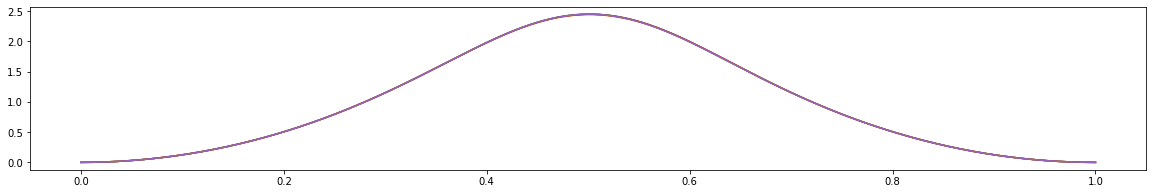

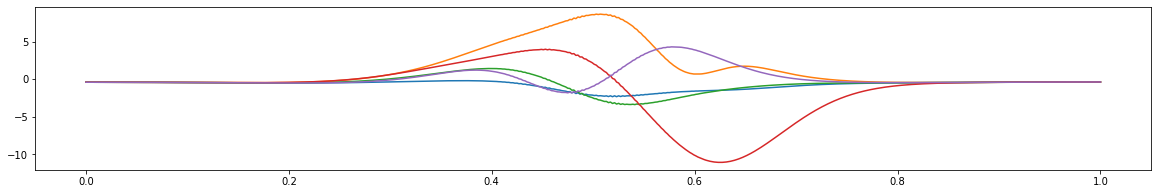

In [0]:
plt.figure(figsize=(20, 3), dpi=dpi)
plt.plot(dataset.x, tf.transpose(density[:preview]))
plt.show()

new_density, functional_derivative = self_consistency_method.step(density, potential)

plt.figure(figsize=(20, 3), dpi=dpi)
plt.plot(dataset.x, tf.transpose(functional_derivative[:preview]))
plt.show()

density = new_density